## Evaluating Coar attributions 

We evaluate pre-computed attributions of a CIFAR-10 ResNet18 model in this notebook.
Specifically, we quantifes the extent to which Coar attributions can accurately predict the counterfactual effect of ablating random $\alpha$-sized component subsets on model outputs.

In [9]:
import sys 
sys.path.append('..')

import functools 
import torch
from torch import nn
import seaborn as sns

from src.models import cifar_resnet
from src.utils import ndm_utils, data_utils
from src.data import ffcv_pipelines
from evaluate import EvaluateCoar, get_masked_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download model, beton, and attributions 

In [9]:
# size ~ 100 MB 
# attributions
!wget 'https://www.dropbox.com/scl/fi/muszxvauowakwvlczjgct/cifar.pt?rlkey=t1kqjusw1p3yr6264cxnnx1f5&dl=0' -O out/cifar_attributions.pt
# model
!wget 'https://www.dropbox.com/scl/fi/ar7fput9rzyxebep0cgqf/cifar.pt?rlkey=y4hmrj94o4vxe4so55z1ebefw&dl=0' -O out/cifar_model.pt
# dataloader in ffcv .beton format
!wget 'https://www.dropbox.com/scl/fi/4zj04xkgnb5mpw4aosvrt/cifar10.beton?rlkey=wspv74qs0h7l5cbxmzntmsywe&dl=0' -O out/cifar.beton

--2024-02-13 02:00:08--  https://www.dropbox.com/scl/fi/muszxvauowakwvlczjgct/cifar.pt?rlkey=t1kqjusw1p3yr6264cxnnx1f5&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd638b01d1da5729f63636e51d3.dl.dropboxusercontent.com/cd/0/inline/CNK1j_kuk3-uJOTdBAknjNShgivSShW_5oSihuAOObdTjk9eHoNx76DE75od---G4P5P29HYYDHpkJVNSCBeqjLIYcDgyxLIlC7k1y7G3o2sOaMRgE-4hekE00ukeA-5hKSwFP1VQxS_a0FN5dRU3vsE/file# [following]
--2024-02-13 02:00:09--  https://ucd638b01d1da5729f63636e51d3.dl.dropboxusercontent.com/cd/0/inline/CNK1j_kuk3-uJOTdBAknjNShgivSShW_5oSihuAOObdTjk9eHoNx76DE75od---G4P5P29HYYDHpkJVNSCBeqjLIYcDgyxLIlC7k1y7G3o2sOaMRgE-4hekE00ukeA-5hKSwFP1VQxS_a0FN5dRU3vsE/file
Resolving ucd638b01d1da5729f63636e51d3.dl.dropboxusercontent.com (ucd638b01d1da5729f63636e51d3.dl.dropboxusercontent.com)... 162.125.4.15, 2620:

### Evaluate 

In [3]:
DEVICE = torch.device(0) 

def get_model():
    model = torch.load('out/cifar_model.pt').cpu().eval()
    return model

def get_attributions():
    A = torch.load('out/cifar_attributions.pt')
    A = A['weight'].T.float()
    return A

def get_loader(batch_size=256, num_workers=2):
    pipeline = ffcv_pipelines.get_pipelines('cifar10', 'test', DEVICE)
    loader = data_utils.get_ffcv_loader('out/cifar.beton', batch_size, num_workers, pipeline, is_train=False)
    return loader

def get_model_components(model):
    def is_component(comp_name):
        valid = 'conv' in comp_name
        return valid

    def get_comp_dim(comp):
        assert type(comp) is nn.Conv2d
        return comp.out_channels

    comp_dims = {}
    for comp_name, comp in model.named_modules():
        if not is_component(comp_name): continue
        key = comp_name+'.weight'
        comp_dims[key] = get_comp_dim(comp)

    return comp_dims

In [4]:
model = get_model()
comps = get_model_components(model)
mask_model_wrapper = functools.partial(get_masked_model, comp_dims=comps)

attb = get_attributions()
loader = get_loader() 

coar_eval = EvaluateCoar(attb, get_model, mask_model_wrapper, loader, attb.shape[1], DEVICE)

In [20]:
mask_probs = [0.1, 0.05, 0.025]
num_runs = 100 
cor_df = coar_eval.get_correlation_dataframe(mask_probs, num_runs, use_tqdm=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


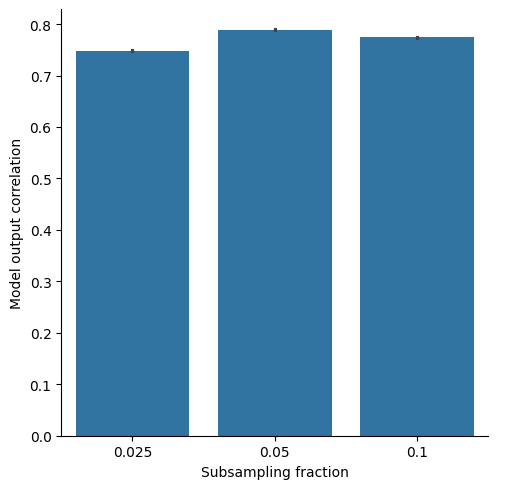

In [21]:
sns.catplot(data=cor_df, x='Subsampling fraction', y='Model output correlation', kind='bar')